# Part 3: Running the model

We've now made it through the hard part; the math for the dynamics model is done, and we've translated it into modular and extensible Python code.
Instantiating the model is a matter of defining the various parameters and then constructing the model components for gravity, vehicle drag, and rotor aerodynamics.

In [ ]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import matplotlib.pyplot as plt
import multirotor
import numpy as np
from scipy.integrate import solve_ivp

import archimedes as arc

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

np.set_printoptions(precision=3, suppress=True)

In [ ]:
m = 2.0  # Body mass [kg]
R = 0.15  # Rotor radius (also boom length) [m]
H = 0.15  # Body height [m]
L = 0.30  # Rotor arm length [m]
rho = 1.225  # Density of air [kg/m^3]
Cd = 1.6  # Drag coefficient [-]
kF = 1e-5  # Force coefficient for rotors [kg-m]
kM = 1e-7  # Moment coefficient for rotors [kg-m^2]
g0 = 9.81  # Gravitational acceleration [m/s^2]

# Inertia matrix of a cylinder with mass m, radius R, and height h
J_B = np.array(
    [
        [m / 12 * (3 * R**2 + H**2), 0, 0],
        [0, m / 12 * (3 * R**2 + H**2), 0],
        [0, 0, m / 2 * R**2],
    ]
)

# Four rotors mounted at 45, 135, 225, and 315 degrees
# No canting and alternating spin directions
rotors = []
theta = np.pi / 4
ccw = True
for i in range(4):
    rotors.append(
        multirotor.RotorGeometry(
            offset=np.array([L * np.cos(theta), L * np.sin(theta), 0]),
            ccw=ccw,
        )
    )
    theta += np.pi / 2
    ccw = not ccw

# Construct the model components for gravity, vehicle drag, and
# rotor aerodynamics
gravity_model = multirotor.ConstantGravity(g0=g0)
drag_model = multirotor.QuadraticDragModel(
    rho=rho,
    Cd=Cd,
    A=R * H,
)
rotor_model = multirotor.QuadraticRotorModel(kF=kF, kM=kM)

# Create the complete vehicle model
vehicle = multirotor.MultiRotorVehicle(
    m=m,
    J_B=J_B,
    rotors=rotors,
    drag_model=drag_model,
    rotor_model=rotor_model,
    gravity_model=gravity_model,
    attitude="euler",
)

This gives us an object `vehicle` with the dynamics function `vehicle.dynamics(t, x, u)`, where `u` is expected to be an array of the inputs.

We'll start with a simple simulation using constant angular velocity, at a value chosen to be slightly less than required to hover.
The vehicle will accelerate rapidly until the velocity-squared body drag balances out gravity (i.e. terminal velocity).
Remember that we've defined our vehicle body frame B as "Forward-Right-Down" and our inertial frame N as "North-East-Down", so that positive body-frame velocity and inertial frame position both indicate "down".

In [3]:
t0 = 0.0
t1 = 100.0
t_span = (t0, t1)

u0 = 500.0 * np.ones(4)  # Rotor angular velocity

x0 = vehicle.State(
    p_N=np.zeros(3),  # Initial position [m]
    att=np.zeros(3),  # Initial roll-pitch-yaw [rad]
    v_B=np.zeros(3),  # Initial velocity [m/s]
    w_B=np.zeros(3),  # Initial angular velocity [rad/s]
)
x0_flat, unravel = arc.tree.ravel(x0)

# vmap_unravel will convert a flat solution (x, t) to a vehicle.State
vmap_unravel = arc.vmap(unravel, in_axes=1, out_axes=1)


# Wrap the vehicle dynamics model in a function with the signature `x_t = f(t, x)`
@arc.compile(kind="SX")
def f(t, x_flat):
    x = unravel(x_flat)
    x_t = vehicle.dynamics(t, x, u0)
    return arc.tree.ravel(x_t)[0]  # Return only the flattened state


t_eval = np.linspace(*t_span, 1000)
sol = solve_ivp(f, t_span, x0_flat, t_eval=t_eval)
xs = vmap_unravel(sol.y)  # Return to vehicle.State format

Text(0.5, 0, 'Time [s]')

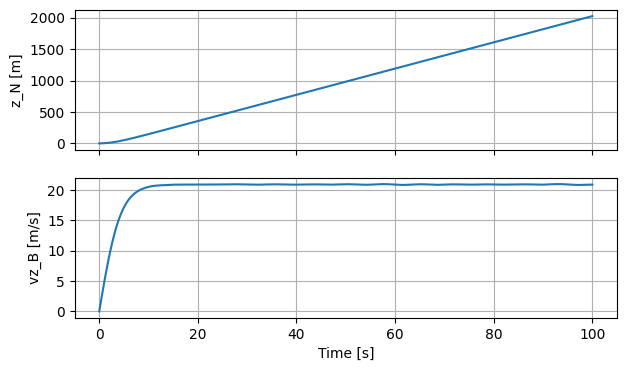

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
ax[0].plot(t_eval, xs.p_N[2], label="z")
ax[0].grid()
ax[0].set_ylabel("z_N [m]")
ax[1].plot(t_eval, xs.v_B[2], label="vz_B")
ax[1].grid()
ax[1].set_ylabel("vz_B [m/s]")
plt.xlabel("Time [s]")

As discussed, it's easy to run the exact same code with Archimedes by simply calling `arc.odeint` instead of `solve_ivp` from SciPy.
This will trigger construction of a symbolic "computational graph" defined by our model and then run the simulation with the SUNDIALS ODE solver.

In [5]:
xs_flat = arc.odeint(f, t_span, x0_flat, t_eval=t_eval)
xs_arc = vmap_unravel(xs_flat)

Text(0.5, 0, 'Time [s]')

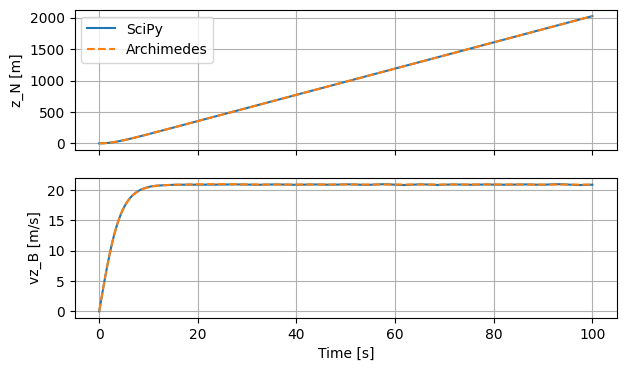

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
ax[0].plot(t_eval, xs.p_N[2], label="SciPy")
ax[0].plot(t_eval, xs_arc.p_N[2], "--", label="Archimedes")
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel("z_N [m]")
ax[1].plot(t_eval, xs.v_B[2])
ax[1].plot(t_eval, xs_arc.v_B[2], "--")
ax[1].grid()
ax[1].set_ylabel("vz_B [m/s]")
plt.xlabel("Time [s]")

In terms of simulation performance, a key difference here is that each time the dynamics function of the NumPy version gets evaluated, the code is executed in regular interpreted Python.
On the other hand, the Archimedes version will evaluate the exact same sequence of operations, but in pre-compiled C++, which can be considerably faster.

We can do a head-to-head comparison using the `%%timeit` magic in Jupyter, which will compare the _entire_ execution time of the simulation call, including the construction of the computational graph and any other setup and initialization.

In [7]:
%%timeit
solve_ivp(f, t_span, x0_flat, t_eval=t_eval)

46.5 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
ys = arc.odeint(f, t_span, x0_flat, t_eval=t_eval)

6.33 ms ± 273 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Here we see about a 5x speedup by running the exact same model with Archimedes instead of pure Python.
Of course, as noted above, it may be possible to improve the performance of the pure NumPy code by pre-allocating vectors or using vectorization wherever possible, although these optimizations tend to decrease readability and may make debugging more difficult.

In absolute terms, the difference between 15ms and 70ms to run a simulation is negligible from a practical point of view.
However, for more complex models this kind of acceleration can make a big difference in simulation throughput, especially when performing optimizations or "batch" simulation runs that vary initial conditions or model parameters.